# Personalized Recommendation System with Graph Neural Networks

**Project Goal:** To build a recommendation system using Graph Neural Networks (GNNs) to predict user engagement with items. We use the MovieLens 1M dataset and explore models like LightGCN and GraphSAGE.





## Phase 1: Setup, Data Loading, and Initial Exploration

**Objective:** Load necessary libraries and the dataset. Perform initial exploration to understand its structure and prepare for graph construction.

**Dataset:** MovieLens 1M. Contains 1 million ratings from ~6,000 users on ~4,000 movies.

**Libraries:** PyTorch, PyTorch Geometric, Pandas, NumPy, Scikit-learn.

In [7]:


import pandas as pd
import numpy as np
import torch
import torch_geometric
import os # Added for path joining
from torch_geometric.data import Data, HeteroData
from torch_geometric.nn import SAGEConv, GATConv, GCNConv, LightGCN, to_hetero
from torch_geometric.loader import LinkNeighborLoader # For link prediction tasks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
import random

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Geometric version: {torch_geometric.__version__}")

PyTorch version: 2.5.1+cu118
PyTorch Geometric version: 2.6.1


### 1.1 Load MovieLens 1M Data

We'll load the `ratings.dat` file, which contains `UserID::MovieID::Rating::Timestamp`.

In [8]:
# Define the base path to your MovieLens 1M directory
base_data_dir = r"C:\Users\amanp\OneDrive - purdue.edu\Spring 2025\Projects\GNN recommendation system\ml-1m"
ratings_filename = 'ratings.dat'
data_path = os.path.join(base_data_dir, ratings_filename)

print(f"Attempting to load MovieLens 1M dataset from: {data_path}")

try:
    df = pd.read_csv(data_path, sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python', encoding='latin-1')
except FileNotFoundError:
    print(f"MovieLens 1M dataset not found at '{data_path}'.")
    print("Please ensure the path is correct and the 'ratings.dat' file exists there.")
    print("You can download MovieLens 1M from: https://grouplens.org/datasets/movielens/1m/")
    # As a fallback, create a small dummy dataframe for the rest of the notebook to run
    # This is NOT representative of the actual dataset and is only for code execution demonstration
    data = {'user_id': [1, 1, 2, 2, 3, 3, 4, 1, 5, 5, 2, 6, 7, 7, 8, 8, 9, 9, 10, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] * 100, # Increased dummy data size slightly
            'item_id': [101, 102, 101, 103, 102, 104, 103, 105, 104, 106, 105, 107, 106, 108, 107, 109, 108, 110, 109, 101, 103, 105, 102, 106, 101, 107, 104, 108, 102, 110] * 100,
            'rating': [5, 3, 4, 2, 5, 1, 4, 3, 5, 2, 4, 5, 3, 4, 2, 5, 1, 4, 3, 5, 2, 4, 5, 3, 4, 2, 5, 1, 4, 3] * 100,
            'timestamp': [978300000 + i for i in range(3000)]}
    df = pd.DataFrame(data)
    print("\nWARNING: Using a small dummy dataset as MovieLens 1M was not found. Results will not be meaningful.")

print("Dataset shape:", df.shape)
df.head()

Attempting to load MovieLens 1M dataset from: C:\Users\amanp\OneDrive - purdue.edu\Spring 2025\Projects\GNN recommendation system\ml-1m\ratings.dat
Dataset shape: (1000209, 4)


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 1.2 Data Preprocessing

* **User and Item ID Encoding:** GNNs typically work with zero-indexed integer IDs. We'll use `LabelEncoder`.
* **Implicit Feedback:** We'll consider all interactions as positive edges in the graph, as both LightGCN and our GraphSAGE variant will model the existence of an interaction for collaborative filtering.
* **Train-Test Split:** Crucial for evaluation. A temporal split is ideal for recommendation (train on past, test on future). For simplicity here, we'll do a random split, but acknowledge temporal splitting as best practice.

In [9]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df['user_idx'] = user_encoder.fit_transform(df['user_id'])
df['item_idx'] = item_encoder.fit_transform(df['item_id'])

num_users = df['user_idx'].nunique()
num_items = df['item_idx'].nunique()
num_interactions = len(df)

print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of interactions: {num_interactions}")
print(f"Sparsity: {1 - num_interactions / (num_users * num_items):.4f}")

# We'll split the interactions to create a training set of edges and a test set of edges.
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['user_idx']) # Stratify by user to ensure users are in both sets

print(f"Training interactions: {len(train_df)}")
print(f"Testing interactions: {len(test_df)}")

Number of unique users: 6040
Number of unique items: 3706
Number of interactions: 1000209
Sparsity: 0.9553
Training interactions: 800167
Testing interactions: 200042


## Phase 2: Graph Construction

**Objective:** Represent the user-item interactions as a bipartite graph. For use with GNNs like LightGCN and GraphSAGE in PyTorch Geometric, we often convert this to a homogeneous graph structure where user and item nodes are part of a single node set, distinguished by their ID range.

User and item features are usually their learnable embeddings, especially for LightGCN. GraphSAGE can also incorporate explicit node features if available.

In [10]:
# We will construct a single graph using all interactions for message passing.
# The train_df and test_df will be used to define positive pairs for training and evaluation.

# Create edge index for the full graph (user-item interactions)
user_nodes_full = torch.tensor(df['user_idx'].values, dtype=torch.long)
item_nodes_full = torch.tensor(df['item_idx'].values, dtype=torch.long)

# For a bipartite graph to be used with these GNNs in PyG, we represent it as a homogeneous graph
# where user nodes are [0, num_users-1] and item nodes are [num_users, num_users+num_items-1].
src_full = user_nodes_full
dst_full = item_nodes_full + num_users # Offset item indices

# Create bidirectional edges
edge_index_full = torch.stack([
    torch.cat([src_full, dst_full]),
    torch.cat([dst_full, src_full])
], dim=0)

graph_data = Data(edge_index=edge_index_full, num_nodes=num_users + num_items)
print("Full graph data for GNNs:")
print(graph_data)

# Prepare train and test edges (positive interactions)
train_user_nodes = torch.tensor(train_df['user_idx'].values, dtype=torch.long)
train_item_nodes = torch.tensor(train_df['item_idx'].values, dtype=torch.long)
train_pos_edge_index = torch.stack([train_user_nodes, train_item_nodes], dim=0)

test_user_nodes = torch.tensor(test_df['user_idx'].values, dtype=torch.long)
test_item_nodes = torch.tensor(test_df['item_idx'].values, dtype=torch.long)
test_pos_edge_index = torch.stack([test_user_nodes, test_item_nodes], dim=0)

print(f"\nShape of training positive edges: {train_pos_edge_index.shape}")
print(f"Shape of testing positive edges: {test_pos_edge_index.shape}")

Full graph data for GNNs:
Data(edge_index=[2, 2000418], num_nodes=9746)

Shape of training positive edges: torch.Size([2, 800167])
Shape of testing positive edges: torch.Size([2, 200042])


## Phase 3: GNN Models

**Objective:** Implement GNN models for recommendation. We'll start with LightGCN and then add GraphSAGE as an alternative advanced model.

### 3.1 LightGCN (Light Graph Convolution Network)

**Rationale:**
* **Simplicity:** Removes feature transformations and non-linearities from traditional GCNs.
* **Effectiveness:** Strong performance for collaborative filtering.
* **Core Idea:** Learns embeddings by linearly propagating them on the user-item graph. Final embedding is a weighted sum from different propagation layers.


In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import LightGCN # Make sure this is imported

# Assume num_users and num_items are defined from your data preprocessing, e.g.:
# num_users = df['user_idx'].nunique()
# num_items = df['item_idx'].nunique()

class LightGCN_Recommender(torch.nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64, num_layers=3, alpha=None):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        # The PyG LightGCN model will manage its own embeddings.
        # Its parameters (including its internal nn.Embedding layer) will be registered
        # when this LightGCN_Recommender module is instantiated.
        self.lightgcn_model = LightGCN(
            num_nodes=num_users + num_items, # Total number of user and item nodes
            embedding_dim=embedding_dim,
            num_layers=num_layers,
            alpha=alpha # If None, alpha is 1/(num_layers+1) for each layer, as in the paper
        )
        # No separate self.user_embedding or self.item_embedding in this wrapper.
        # PyG's LightGCN initializes its internal nn.Embedding using xavier_uniform_ by default.

    def forward(self, edge_index):
        """
        Performs message passing using the internal LightGCN model to get final embeddings.
        """
        # Ensure edge_index is of the correct type and contiguous for PyG operations.
        current_edge_index = edge_index.long().contiguous()

        # Call the get_embedding method of the PyG LightGCN model.
        # This method uses the LightGCN model's own internal embedding layer
        # and performs the light graph convolution.
        final_embeddings = self.lightgcn_model.get_embedding(edge_index=current_edge_index)
        
        # Split the combined embeddings back into user and item embeddings
        final_user_emb, final_item_emb = torch.split(final_embeddings, [self.num_users, self.num_items], dim=0)
        return final_user_emb, final_item_emb

    def predict_score(self, user_indices, item_indices, user_emb, item_emb):
        """
        Predicts the interaction score between given users and items
        based on their final embeddings.
        """
        # Select embeddings for the given user and item indices
        u_emb = user_emb[user_indices]
        i_emb = item_emb[item_indices]
        # Compute dot product
        return torch.sum(u_emb * i_emb, dim=1)

    def bpr_loss(self, user_emb, item_emb, pos_user_indices, pos_item_indices, neg_item_indices):
        """
        Calculates the Bayesian Personalized Ranking (BPR) loss.
        user_emb and item_emb are the final embeddings obtained from the forward pass.
        """
        # Calculate scores for positive user-item pairs
        pos_scores = self.predict_score(pos_user_indices, pos_item_indices, user_emb, item_emb)
        # Calculate scores for negative user-item pairs (same users, different items)
        neg_scores = self.predict_score(pos_user_indices, neg_item_indices, user_emb, item_emb)
        
        # BPR loss formula
        loss = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-8).mean()
        return loss

### 3.2 GraphSAGE (Graph Sample and Aggregate)

**Rationale:**
* **Inductive Learning:** Can generate embeddings for unseen nodes (though in this MovieLens setup, all nodes are typically seen during training, its architecture is inherently inductive).
* **Neighborhood Aggregation:** Learns to aggregate feature information from a node's local neighborhood. Different aggregator functions (mean, GCN, LSTM, pooling) can be used.
* **Flexibility:** Can incorporate node features if available, potentially leading to better performance when collaborative signals are sparse or for cold-start scenarios.

For this implementation, we'll use learnable embeddings for users and items as initial features, similar to how LightGCN starts, and then apply GraphSAGE convolutions.

In [20]:
class GraphSAGE_Recommender(torch.nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64, num_layers=2, dropout_rate=0.1):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        # User and Item embedding layers
        self.user_embedding = torch.nn.Embedding(num_users, embedding_dim)
        self.item_embedding = torch.nn.Embedding(num_items, embedding_dim)

        # GraphSAGE convolution layers
        self.convs = torch.nn.ModuleList()
        # First layer: input is the initial embedding dimension
        self.convs.append(SAGEConv(embedding_dim, embedding_dim))
        # Subsequent layers
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(embedding_dim, embedding_dim))
        
        self.dropout = torch.nn.Dropout(self.dropout_rate)

        # Initialize weights
        torch.nn.init.xavier_normal_(self.user_embedding.weight)
        torch.nn.init.xavier_normal_(self.item_embedding.weight)

    def get_initial_embeddings(self):
        """Concatenates initial user and item embeddings to form input node features."""
        return torch.cat([self.user_embedding.weight, self.item_embedding.weight], dim=0)

    def forward(self, edge_index):
        # Get initial node features (concatenated user and item embeddings)
        x = self.get_initial_embeddings()
        
        # Apply GraphSAGE layers
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < self.num_layers - 1: # No activation/dropout after the last conv layer's output if used directly for dot product
                x = F.relu(x)
                x = self.dropout(x)
        
        # Split back into user and item embeddings
        final_user_emb, final_item_emb = torch.split(x, [self.num_users, self.num_items], dim=0)
        return final_user_emb, final_item_emb

    def predict_score(self, user_indices, item_indices, user_emb, item_emb):
        u_emb = user_emb[user_indices]
        i_emb = item_emb[item_indices]
        return torch.sum(u_emb * i_emb, dim=1) # Dot product

    def bpr_loss(self, user_emb, item_emb, pos_user_indices, pos_item_indices, neg_item_indices):
        pos_scores = self.predict_score(pos_user_indices, pos_item_indices, user_emb, item_emb)
        neg_scores = self.predict_score(pos_user_indices, neg_item_indices, user_emb, item_emb)
        loss = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-8).mean()
        return loss


### 3.3 Model Configuration and Instantiation

Choose the model you want to train and evaluate.

In [21]:
# MODEL_CHOICE: 'LightGCN' or 'GraphSAGE'
MODEL_CHOICE = 'LightGCN' # Change this to 'GraphSAGE' to use the other model

# Model Hyperparameters
EMBEDDING_DIM = 64
NUM_LAYERS = 3    # For LightGCN: number of propagation layers.
                  # For GraphSAGE: number of SAGEConv layers (e.g., 2 or 3 is common).
GRAPHSAGE_DROPOUT = 0.1 # Dropout for GraphSAGE, not used by LightGCN here
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4 # L2 regularization for embeddings
BATCH_SIZE = 2048 
EPOCHS = 50 # Might need adjustment for ML-1M (e.g., fewer epochs if converges faster, or more if needed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if MODEL_CHOICE == 'LightGCN':
    print("Initializing LightGCN Model...")
    model = LightGCN_Recommender(num_users, num_items, EMBEDDING_DIM, NUM_LAYERS).to(device)
elif MODEL_CHOICE == 'GraphSAGE':
    print("Initializing GraphSAGE Model...")
    # Note: NUM_LAYERS for GraphSAGE is typically 2-3. If using 3 for LightGCN, 2 might be a good start for GraphSAGE.
    model = GraphSAGE_Recommender(num_users, num_items, EMBEDDING_DIM, num_layers=NUM_LAYERS, dropout_rate=GRAPHSAGE_DROPOUT).to(device)
else:
    raise ValueError("Invalid MODEL_CHOICE. Choose 'LightGCN' or 'GraphSAGE'.")

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# The graph_data.edge_index is used for message passing and should be on the same device as the model
graph_data = graph_data.to(device)
print("\nModel initialized and moved to device:")
print(model)

Using device: cuda
Initializing LightGCN Model...

Model initialized and moved to device:
LightGCN_Recommender(
  (lightgcn_model): LightGCN(9746, 64, num_layers=3)
)


## Phase 4: Training the Model

**Objective:** Train the selected GNN model using BPR loss.

**BPR Loss (Bayesian Personalized Ranking):**
* Assumes users prefer items they interacted with over items they haven't.
* For each positive user-item pair `(u, i+)`, a negative item `i-` (not interacted with by `u`) is sampled.
* The loss aims to maximize the score difference between `(u, i+)` and `(u, i-)`.

**Training Loop:**
1.  Get current user and item embeddings from the GNN (after propagation on the full graph).
2.  Sample a batch of positive interactions `(u, i+)` from `train_pos_edge_index`.
3.  For each `(u, i+)`, sample a negative item `i-` (an item `u` has not interacted with).
4.  Calculate BPR loss using the embeddings.
5.  Backpropagate and update model parameters (embeddings).

Starting training for LightGCN model...
Epoch 5/50, Model: LightGCN, Average BPR Loss: 0.6019
Epoch 10/50, Model: LightGCN, Average BPR Loss: 0.6016
Epoch 15/50, Model: LightGCN, Average BPR Loss: 0.6020
Epoch 20/50, Model: LightGCN, Average BPR Loss: 0.6017
Epoch 25/50, Model: LightGCN, Average BPR Loss: 0.6016
Epoch 30/50, Model: LightGCN, Average BPR Loss: 0.6021
Epoch 35/50, Model: LightGCN, Average BPR Loss: 0.6020
Epoch 40/50, Model: LightGCN, Average BPR Loss: 0.6020
Epoch 45/50, Model: LightGCN, Average BPR Loss: 0.6018
Epoch 50/50, Model: LightGCN, Average BPR Loss: 0.6022
Training finished for LightGCN model.


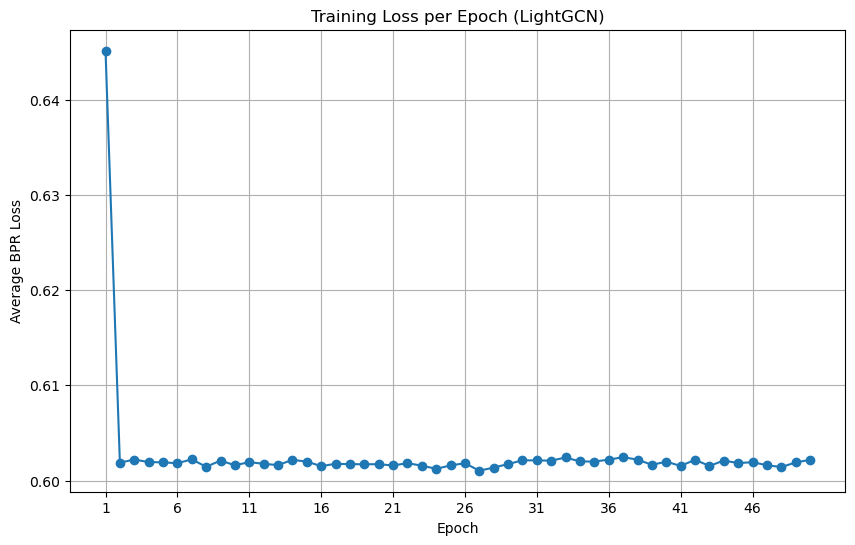

In [23]:
import matplotlib.pyplot as plt # Import matplotlib
# --- (your existing imports and code before this snippet) ---

def sample_negative_items(user_idx, num_items, positive_items_for_user, num_samples=1):
    """Samples negative items for a given user."""
    neg_items = []
    if not isinstance(positive_items_for_user, set):
        positive_items_for_user_set = set(positive_items_for_user.tolist() if isinstance(positive_items_for_user, torch.Tensor) else positive_items_for_user)
    else:
        positive_items_for_user_set = positive_items_for_user

    while len(neg_items) < num_samples:
        sampled_item = random.randint(0, num_items - 1)
        if sampled_item not in positive_items_for_user_set:
            neg_items.append(sampled_item)
    return torch.tensor(neg_items, dtype=torch.long)

user_to_positive_items_train = train_df.groupby('user_idx')['item_idx'].apply(list).to_dict()

print(f"Starting training for {MODEL_CHOICE} model...")

# List to store average loss per epoch for plotting
epoch_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0 # Initialize as float
    num_processed_samples = 0 # To correctly average loss if train_pos_edge_index.size(1) is 0

    # Shuffle training data (positive edges)
    shuffled_indices = torch.randperm(train_pos_edge_index.size(1))
    shuffled_train_pos_edge_index = train_pos_edge_index[:, shuffled_indices]
    
    # Iterate over mini-batches
    for i in range(0, shuffled_train_pos_edge_index.size(1), BATCH_SIZE):
        optimizer.zero_grad()
        
        # Key Change: GNN forward pass (message passing) is now INSIDE the batch loop.
        # This creates a fresh computation graph for each batch's backward pass.
        # The model's parameters (embeddings, GNN weights) are updated by optimizer.step(),
        # so subsequent calls to model() will use the updated parameters.
        user_embeddings_batch, item_embeddings_batch = model(graph_data.edge_index)
        
        batch_pos_edges = shuffled_train_pos_edge_index[:, i:i+BATCH_SIZE]
        pos_user_indices = batch_pos_edges[0, :].to(device)
        pos_item_indices = batch_pos_edges[1, :].to(device)
        
        # Sample negative items for each positive pair in the batch
        batch_neg_item_indices_list = []
        for user_idx_val in pos_user_indices.cpu().tolist(): 
            positive_items_for_this_user = user_to_positive_items_train.get(user_idx_val, [])
            # Ensure negative sampling is done correctly with item_idx values
            neg_sample = sample_negative_items(user_idx_val, num_items, 
                                               set(positive_items_for_this_user), 
                                               num_samples=1) # Assuming BPR needs one negative sample per positive
            batch_neg_item_indices_list.append(neg_sample)
        
        if not batch_neg_item_indices_list: 
            # This case should ideally not happen if pos_user_indices is not empty
            continue

        batch_neg_item_indices = torch.cat(batch_neg_item_indices_list).to(device)
        
        # Ensure batch_neg_item_indices has the same length as pos_user_indices
        if len(batch_neg_item_indices) != len(pos_user_indices):
            # This might happen if sampling issues occur or if a user has interacted with all items
            # print(f"Warning: Skipping batch due to mismatch in positive ({len(pos_user_indices)}) and negative ({len(batch_neg_item_indices)}) samples.")
            continue

        # Calculate BPR loss using the embeddings computed for THIS batch
        loss = model.bpr_loss(user_embeddings_batch, item_embeddings_batch, 
                              pos_user_indices, pos_item_indices, 
                              batch_neg_item_indices)
        
        loss.backward() # Backpropagate for the current batch
        optimizer.step() # Update model parameters
        
        total_loss += loss.item() * pos_user_indices.size(0) # Accumulate weighted loss
        num_processed_samples += pos_user_indices.size(0)
        
    if num_processed_samples > 0:
        avg_loss = total_loss / num_processed_samples
    else:
        avg_loss = 0.0 # Handle case with no processed samples (e.g., empty train_pos_edge_index)
        
    epoch_losses.append(avg_loss) # Store average loss for this epoch

    if (epoch + 1) % 5 == 0: # Or any other frequency for printing
        print(f"Epoch {epoch+1}/{EPOCHS}, Model: {MODEL_CHOICE}, Average BPR Loss: {avg_loss:.4f}")

print(f"Training finished for {MODEL_CHOICE} model.")

# Plotting the training loss
if EPOCHS > 0 and epoch_losses: # Ensure there's data to plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-')
    plt.title(f'Training Loss per Epoch ({MODEL_CHOICE})')
    plt.xlabel('Epoch')
    plt.ylabel('Average BPR Loss')
    # Ensure xticks match the number of epochs plotted
    plotted_epochs = len(epoch_losses)
    if plotted_epochs > 0:
        plt.xticks(range(1, plotted_epochs + 1, max(1, plotted_epochs // 10))) # Adjust tick frequency for many epochs
    plt.grid(True)
    plt.show()
else:
    print("No training epochs were run or no losses recorded, skipping plot.")

## Phase 5: Evaluation

**Objective:** Evaluate the trained model on the test set using common recommendation metrics.

**Metrics:**
* **Precision@K:** Proportion of recommended items in the top-K set that are relevant.
* **Recall@K:** Proportion of relevant items that are successfully recommended in the top-K set.
* **NDCG@K (Normalized Discounted Cumulative Gain):** Considers the position of hits in the top-K list.

**Evaluation Process:**
1.  Get the final learned user and item embeddings.
2.  For each user in the test set:
    a.  Predict scores for all items (or a large set of unobserved items + true positive test items).
    b.  Rank items based on scores.
    c.  Compare top-K recommendations against the user's actual positive interactions in the test set.
3.  Average metrics across all test users.

In [24]:
def get_user_positive_items_test(test_df_user):
    """Returns a set of item_idx that the user has positively interacted with in the test set."""
    return set(test_df_user['item_idx'].tolist())

@torch.no_grad()
def evaluate_model(model_to_eval, graph_data_eval, test_df_eval, user_to_train_items_map, num_users_eval, num_items_eval, K=20, device_eval='cpu'):
    model_to_eval.eval()
    
    final_user_emb, final_item_emb = model_to_eval(graph_data_eval.edge_index)
    final_user_emb = final_user_emb.to(device_eval)
    final_item_emb = final_item_emb.to(device_eval)

    precisions = []
    recalls = []
    ndcgs = []

    test_users = test_df_eval['user_idx'].unique()

    for user_idx in test_users:
        train_pos_items = set(user_to_train_items_map.get(user_idx, []))
        true_pos_items_test = get_user_positive_items_test(test_df_eval[test_df_eval['user_idx'] == user_idx])
        if not true_pos_items_test:
            continue

        user_embedding_single = final_user_emb[user_idx].unsqueeze(0)
        all_item_scores = torch.matmul(user_embedding_single, final_item_emb.T).squeeze()
        
        for train_item_idx in train_pos_items:
            if 0 <= train_item_idx < num_items_eval:
                 all_item_scores[train_item_idx] = -torch.inf
        
        _, top_k_indices = torch.topk(all_item_scores, k=K)
        recommended_items = set(top_k_indices.cpu().tolist())

        hits = recommended_items.intersection(true_pos_items_test)
        
        precision_at_k = len(hits) / K if K > 0 else 0
        precisions.append(precision_at_k)
        
        recall_at_k = len(hits) / len(true_pos_items_test) if len(true_pos_items_test) > 0 else 0
        recalls.append(recall_at_k)
        
        relevance = torch.zeros(K, device=device_eval)
        for i, item_r_idx in enumerate(top_k_indices.tolist()):
            if item_r_idx in true_pos_items_test:
                relevance[i] = 1
        
        ideal_relevance_len = min(K, len(true_pos_items_test))
        idcg_val = torch.sum(1.0 / torch.log2(torch.arange(2, ideal_relevance_len + 2, device=device_eval).float()))
        dcg_val = torch.sum(relevance / torch.log2(torch.arange(2, K + 2, device=device_eval).float()))
        ndcg_at_k = (dcg_val / idcg_val).item() if idcg_val > 0 else 0
        ndcgs.append(ndcg_at_k)

    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0
    avg_ndcg = np.mean(ndcgs) if ndcgs else 0
    
    return avg_precision, avg_recall, avg_ndcg

print(f"\nEvaluating {MODEL_CHOICE} model...")
eval_precision, eval_recall, eval_ndcg = evaluate_model(model, graph_data, test_df, user_to_positive_items_train, num_users, num_items, K=20, device_eval=device)

print(f"Evaluation Results for {MODEL_CHOICE} (K=20):")
print(f"  Precision@20: {eval_precision:.4f}")
print(f"  Recall@20:    {eval_recall:.4f}")
print(f"  NDCG@20:      {eval_ndcg:.4f}")


Evaluating LightGCN model...
Evaluation Results for LightGCN (K=20):
  Precision@20: 0.1566
  Recall@20:    0.1137
  NDCG@20:      0.1955


### 5.1 Example: Generating Recommendations for a Sample User

In [25]:
@torch.no_grad()
def recommend_for_user(user_idx_target, model_eval, graph_data_rec, user_to_train_items_map_rec, num_items_rec, item_encoder_rec, K=10, device_rec='cpu'):
    model_eval.eval()
    final_user_emb_rec, final_item_emb_rec = model_eval(graph_data_rec.edge_index)
    final_user_emb_rec = final_user_emb_rec.to(device_rec)
    final_item_emb_rec = final_item_emb_rec.to(device_rec)

    train_pos_items_rec = set(user_to_train_items_map_rec.get(user_idx_target, []))
    
    user_embedding_single_rec = final_user_emb_rec[user_idx_target].unsqueeze(0)
    all_item_scores_rec = torch.matmul(user_embedding_single_rec, final_item_emb_rec.T).squeeze()
    
    for train_item_idx_rec in train_pos_items_rec:
        if 0 <= train_item_idx_rec < num_items_rec:
            all_item_scores_rec[train_item_idx_rec] = -torch.inf
            
    _, top_k_indices_rec = torch.topk(all_item_scores_rec, k=K)
    recommended_item_indices = top_k_indices_rec.cpu().tolist()
    
    try:
        recommended_original_ids = item_encoder_rec.inverse_transform(recommended_item_indices)
    except IndexError:
        print(f"Warning: Could not inverse_transform some item indices. Max index: {max(recommended_item_indices)}, encoder classes: {len(item_encoder_rec.classes_)}")
        recommended_original_ids = [f"item_idx_{idx}" for idx in recommended_item_indices] 

    return recommended_original_ids

if not test_df.empty:
    sample_user_original_id = test_df['user_id'].sample(1).iloc[0]
    sample_user_idx = user_encoder.transform([sample_user_original_id])[0]
    print(f"\nGenerating recommendations for sample user_id: {sample_user_original_id} (user_idx: {sample_user_idx}) using {MODEL_CHOICE} model")

    known_positives_train_orig_ids = []
    if sample_user_idx in user_to_positive_items_train:
        known_positives_train_indices = user_to_positive_items_train[sample_user_idx][:5]
        try:
           known_positives_train_orig_ids = item_encoder.inverse_transform(known_positives_train_indices)
        except IndexError:
            known_positives_train_orig_ids = [f"item_idx_{idx}" for idx in known_positives_train_indices]
    print(f"  User liked in training (first 5, not recommended): {list(known_positives_train_orig_ids)}")

    true_positives_test_orig_ids = []
    user_test_data = test_df[test_df['user_idx'] == sample_user_idx]
    if not user_test_data.empty:
        true_positives_test_indices = user_test_data['item_idx'].unique()[:5]
        try:
            true_positives_test_orig_ids = item_encoder.inverse_transform(true_positives_test_indices)
        except IndexError:
            true_positives_test_orig_ids = [f"item_idx_{idx}" for idx in true_positives_test_indices]
    print(f"  User liked in test (ground truth, first 5): {list(true_positives_test_orig_ids)}")

    recommendations = recommend_for_user(sample_user_idx, model, graph_data, user_to_positive_items_train, num_items, item_encoder, K=10, device_rec=device)
    print(f"\n  Top 10 Recommended item_ids for user {sample_user_original_id} (using {MODEL_CHOICE}): {recommendations}")
else:
    print("\nTest dataframe is empty, cannot generate sample recommendations.")


Generating recommendations for sample user_id: 621 (user_idx: 620) using LightGCN model
  User liked in training (first 5, not recommended): [2606, 1721, 2580, 382, 2560]
  User liked in test (ground truth, first 5): [1623, 2355, 1120, 2762, 2770]

  Top 10 Recommended item_ids for user 621 (using LightGCN): [ 260 1210 2028 2571 1270  593 1198  608 2762 1197]


## Phase 6: Discussion, Critical Analysis, and Next Steps

**Objective:** Reflect on the project, its limitations, and potential improvements. This is crucial for an interview setting.

### 6.1 Model Performance and Limitations
* **Performance:** The achieved Precision/Recall/NDCG values provide a quantitative measure. Compare results between LightGCN and GraphSAGE. Note any differences in training time or convergence. Compare against standard benchmarks for MovieLens 1M if available (though exact setup varies).
* **Dataset:** MovieLens 1M is a good benchmark but differs from short video platforms:
    * **Interaction Types:** TikTok has richer interactions. We modeled only positive interactions (ratings).
    * **Content Features:** We haven't used explicit movie/user features (genres, demographics) in these GNNs yet, though GraphSAGE is well-suited for them. LightGCN often performs best with only collaborative signals.
    * **Social Graph:** TikTok has a strong social component, not modeled here.
    * **Dynamic Nature:** Our models are static once trained.
* **Cold Start:** Both LightGCN and this GraphSAGE variant (relying on learned ID embeddings) suffer from cold start for new users/items.
* **Scalability:** Scaling to TikTok's level requires distributed training, graph partitioning, and efficient embedding stores.
* **Negative Sampling:** Our random negative sampling is basic. More advanced techniques can improve performance.
* **GraphSAGE Aggregation:** We used the default mean aggregator in SAGEConv. Exploring other aggregators (LSTM, pooling) could yield different results.

### 6.2 Potential Improvements and Future Work (TikTok Context)

1.  **Richer Graph Schema (Heterogeneous Graph):**
    * **Nodes:** `User`, `Video`, `Creator`, `Topic`/`Hashtag`, `Sound`.
    * **Edges:** `User-watches-Video` (with features like watch_time_%), `User-likes-Video`, `User-shares-Video`, `User-follows-Creator`, `Video-has_topic-Topic`, `Video-uses_sound-Sound`, `User-follows-User`.
    * **Model:** Use GNNs designed for heterogeneous graphs like RGCN, HAN, or `HeteroConv` in PyG. This would be a natural next step for models like GraphSAGE or GAT.

2.  **Incorporate Content Features:**
    * Load movie genres from `movies.dat` (for MovieLens) or extract embeddings from video frames, audio, text for a TikTok-like scenario.
    * For GraphSAGE/GAT: Concatenate these features with or use them as initial node features. This can help with cold-start and content-aware recommendations.
    * For LightGCN: Generally, it's found to perform best without explicit features, but hybrid versions exist.

3.  **Advanced GNN Architectures:**
    * **GAT (Graph Attention Network):** Implement GAT to allow nodes to weigh the importance of neighbors, adding more expressiveness. This is a strong candidate for the next model to try.
    * **PinSage (Pinterest):** Study and potentially implement key ideas from PinSage, designed for web-scale recommendation (e.g., random walk-based convolutions, multi-hop sampling).

4.  **Temporal Dynamics:**
    * Incorporate timestamps of interactions more directly into the GNN, perhaps using Temporal Graph Networks (TGNs) or by creating time-aware node/edge features.

5.  **Advanced Negative Sampling:**
    * Implement more sophisticated negative sampling strategies: 
        * **Popularity-based sampling:** Sample popular items less frequently as negatives.
        * **Hard negative mining:** Sample items that the model currently scores high but are not true positives.
        * **In-batch negatives:** Use other items within the same batch as negatives.

6.  **Multi-Task Learning:** Predict multiple engagement types simultaneously.

7.  **Scalability Solutions:** Discuss graph sampling (NeighborSampler, GraphSAINT), distributed training (PyTorch Distributed, DistDGL), and embedding serving (Faiss).

8.  **Explainability:** Explore methods like GNNExplainer to understand model predictions.

9.  **Hyperparameter Optimization:** Use tools like Optuna or Ray Tune for systematic hyperparameter search for embedding dimensions, number of layers, learning rates, etc., for each GNN model.

In [28]:
import nbformat
from nbconvert import HTMLExporter
import os

def convert_this_notebook_to_html():
    notebook_path = 'GNN_Recommendation_System.ipynb'  # Update if different
    output_html_path = notebook_path.replace('.ipynb', '.html')

    if not os.path.exists(notebook_path):
        print(f"Notebook not found: {notebook_path}")
        return

    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook_node = nbformat.read(f, as_version=4)

    html_exporter = HTMLExporter()
    (body, _) = html_exporter.from_notebook_node(notebook_node)

    with open(output_html_path, 'w', encoding='utf-8') as f:
        f.write(body)

    print(f"Notebook converted to: {output_html_path}")

convert_this_notebook_to_html()


c:\Users\amanp\anaconda3\Lib\site-packages\nbformat\__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


Notebook converted to: GNN_Recommendation_System.html
